# TAREA 2: Optimización de la Función de Rastrigin mediante Algoritmos Genéticos

Implementación de dos variantes de algoritmo genético para encontrar la solución óptima de la función de Rastrigin:

**Función de Rastrigin:**
f(x,y) = 20 + (x² - 10cos(2πx)) + (y² - 10cos(2πy))

**Dominio:** x,y ∈ [-5.12, 5.12]
**Solución óptima:** [0,0; 0]

**Variante 1:**
- Selección: torneo
- Cruzamiento: dos puntos
- Mutación: simple
- Sustitución: extintiva con elitismo

**Variante 2:**
- Cruzamiento: Elitista con operador por dos puntos (cruza todos los individuos)
- Mutación: simple
- Sustitución: Por familia

In [23]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from statistics import median, stdev

## Parámetros del problema

In [24]:
# Parámetros del problema de Rastrigin
x_limits = [-5.12, 5.12]
y_limits = [-5.12, 5.12]
precision = 5  # 5 lugares decimales según la tarea

# Parámetros del algoritmo genético
tam_poblacion = 50
num_generaciones = 200
num_ejecuciones = 10
prob_cruzamiento = 0.8
prob_mutacion = 0.01

# Cálculo de límites y longitudes de bits
liX, lsX = x_limits[0], x_limits[1]
liY, lsY = y_limits[0], y_limits[1]

Lx = int(math.log((lsX-liX)*math.pow(10,precision),2)+0.9)
Ly = int(math.log((lsY-liY)*math.pow(10,precision),2)+0.9)
L_total = Lx + Ly

print(f"Longitud de X = {Lx} bits")
print(f"Longitud de Y = {Ly} bits")
print(f"Longitud total = {L_total} bits")
print(f"Rango X: [{liX}, {lsX}]")
print(f"Rango Y: [{liY}, {lsY}]")

Longitud de X = 20 bits
Longitud de Y = 20 bits
Longitud total = 40 bits
Rango X: [-5.12, 5.12]
Rango Y: [-5.12, 5.12]


## Función de Rastrigin y Fitness

In [37]:
def funcion_rastrigin(x, y):
    """
    Función de Rastrigin para minimización
    f(x,y) = 20 + (x² - 10cos(2πx)) + (y² - 10cos(2πy))
    Mínimo global en (0,0) con valor 0
    """
    return 20 + (x**2 - 10*math.cos(2*math.pi*x)) + (y**2 - 10*math.cos(2*math.pi*y))

def fitness(x, y):
    """
    Función de fitness (negativo de Rastrigin)
    Maximizar fitness = Minimizar Rastrigin
    """
    return -funcion_rastrigin(x, y)

# Probamos las funciones
print(f"Rastrigin(0,0) = {funcion_rastrigin(0, 0)}")
print(f"Fitness(0,0) = {fitness(0, 0)}")
print(f"Rastrigin(1,1) = {funcion_rastrigin(1, 1):.4f}")
print(f"Fitness(1,1) = {fitness(1, 1):.4f}")

Rastrigin(0,0) = 0.0
Fitness(0,0) = -0.0
Rastrigin(1,1) = 2.0000
Fitness(1,1) = -2.0000


## Funciones de codificación y decodificación

In [38]:
def generar_individuo():
    """Genera un individuo aleatorio (cromosoma binario)"""
    bits_x = random.getrandbits(Lx)
    bits_y = random.getrandbits(Ly)

    cromosoma_x = format(bits_x, f'0{Lx}b')
    cromosoma_y = format(bits_y, f'0{Ly}b')

    return cromosoma_x + cromosoma_y

def decodificar_individuo(cromosoma):
    """Decodifica un cromosoma binario a valores reales x, y"""
    bits_x = cromosoma[:Lx]
    bits_y = cromosoma[Lx:]

    x_entero = int(bits_x, 2)
    y_entero = int(bits_y, 2)

    x_real = liX + ((x_entero * (lsX - liX)) / (math.pow(2, Lx) - 1))
    y_real = liY + ((y_entero * (lsY - liY)) / (math.pow(2, Ly) - 1))

    return x_real, y_real

def evaluar_individuo(cromosoma):
    """Evalúa un individuo y retorna x, y, fitness y valor de Rastrigin"""
    x, y = decodificar_individuo(cromosoma)
    f_rastrigin = funcion_rastrigin(x, y)
    f_fitness = fitness(x, y)
    return x, y, f_fitness, f_rastrigin

## Generación de población inicial

In [39]:
def generar_poblacion_inicial(tam_poblacion):
    """Genera la población inicial de individuos"""
    poblacion = []

    for i in range(tam_poblacion):
        cromosoma = generar_individuo()
        x, y, f_fitness, f_rastrigin = evaluar_individuo(cromosoma)

        individuo = {
            'cromosoma': cromosoma,
            'x': x,
            'y': y,
            'fitness': f_fitness,
            'rastrigin': f_rastrigin
        }
        poblacion.append(individuo)

    return poblacion

# Probamos generando una población pequeña
poblacion_test = generar_poblacion_inicial(5)

print("Población inicial de prueba:")
print(f"{'Ind':<3} {'X':<10} {'Y':<10} {'Fitness':<10} {'Rastrigin':<10}")
print("-" * 50)

for i, individuo in enumerate(poblacion_test):
    print(f"{i+1:2d}  {individuo['x']:10.4f} {individuo['y']:10.4f} {individuo['fitness']:10.4f} {individuo['rastrigin']:10.4f}")

Población inicial de prueba:
Ind X          Y          Fitness    Rastrigin 
--------------------------------------------------
 1     -4.9087     0.8531   -30.3876    30.3876
 2      3.1980     2.5277   -43.2584    43.2584
 3     -4.2232    -2.9323   -35.6458    35.6458
 4     -2.3467    -1.9900   -25.1944    25.1944
 5     -3.5843    -0.2520   -41.6653    41.6653


## Selección por torneo (siguiendo pseudocódigo de la clase)

In [40]:
def seleccion_torneo(poblacion):
    """
    Selección por torneo siguiendo el pseudocódigo de la clase (página 41)
    """
    Np = len(poblacion)

    # Crear matriz de padres
    padres = []

    # Crear matriz de torneos con permutaciones aleatorias
    indices = list(range(Np))
    torneo_col1 = indices.copy()
    torneo_col2 = indices.copy()
    random.shuffle(torneo_col1)
    random.shuffle(torneo_col2)

    # Determinar ganador de cada torneo
    for i in range(Np):
        competidor1 = poblacion[torneo_col1[i]]
        competidor2 = poblacion[torneo_col2[i]]

        # El de mayor fitness gana (porque usamos -rastrigin)
        if competidor1['fitness'] > competidor2['fitness']:
            padres.append(competidor1)
        else:
            padres.append(competidor2)

    return padres

# Probamos la selección
seleccionados_test = seleccion_torneo(poblacion_test)
print("Individuos seleccionados:")
for i, individuo in enumerate(seleccionados_test):
    print(f"Seleccionado {i+1}: fitness = {individuo['fitness']:.4f}")

Individuos seleccionados:
Seleccionado 1: fitness = -25.1944
Seleccionado 2: fitness = -30.3876
Seleccionado 3: fitness = -35.6458
Seleccionado 4: fitness = -30.3876
Seleccionado 5: fitness = -25.1944


## Cruzamiento de dos puntos (siguiendo pseudocódigo de la clase)

In [41]:
def cruzamiento_dos_puntos(padres, prob_cruzamiento):
    """
    Cruzamiento de dos puntos siguiendo el pseudocódigo de la clase (páginas 48-51)
    """
    Np = len(padres)
    hijos = []

    # Procesar padres de dos en dos
    for i in range(0, Np - 1, 2):
        if random.random() <= prob_cruzamiento:
            # Generar dos puntos de corte aleatorios distintos
            pto1 = random.randint(1, L_total - 2)
            pto2 = random.randint(pto1 + 1, L_total - 1)

            cromosoma1 = padres[i]['cromosoma']
            cromosoma2 = padres[i + 1]['cromosoma']

            # Crear hijos intercambiando segmentos
            hijo1 = cromosoma1[:pto1] + cromosoma2[pto1:pto2] + cromosoma1[pto2:]
            hijo2 = cromosoma2[:pto1] + cromosoma1[pto1:pto2] + cromosoma2[pto2:]

            hijos.append(hijo1)
            hijos.append(hijo2)
        else:
            # Sin cruzamiento, los padres pasan directamente
            hijos.append(padres[i]['cromosoma'])
            hijos.append(padres[i + 1]['cromosoma'])

    # Si hay un número impar de padres, agregar el último
    if Np % 2 == 1:
        hijos.append(padres[-1]['cromosoma'])

    return hijos

# Probamos el cruzamiento
padre1 = poblacion_test[0]
padre2 = poblacion_test[1]
print(f"Padre 1: {padre1['cromosoma']}")
print(f"Padre 2: {padre2['cromosoma']}")

# Hacemos cruzamiento con probabilidad 1.0 para ver el resultado
hijos_test = cruzamiento_dos_puntos([padre1, padre2], 1.0)
print(f"Hijo 1:  {hijos_test[0]}")
print(f"Hijo 2:  {hijos_test[1]}")

Padre 1: 0000010101001000010110010101010101000001
Padre 2: 1100111111110011011010111111001100010001
Hijo 1:  0000010101001000010110010101000101000001
Hijo 2:  1100111111110011011010111111011100010001


## Mutación simple (siguiendo pseudocódigo de la clase)

In [42]:
def mutacion_simple(cromosomas, prob_mutacion):
    """
    Mutación simple (bit flip) siguiendo el pseudocódigo de la clase (página 54)
    """
    cromosomas_mutados = []

    for cromosoma in cromosomas:
        cromosoma_mutado = ""

        for bit in cromosoma:
            if random.random() <= prob_mutacion:
                # Cambiar el bit (0->1, 1->0)
                cromosoma_mutado += '1' if bit == '0' else '0'
            else:
                cromosoma_mutado += bit

        cromosomas_mutados.append(cromosoma_mutado)

    return cromosomas_mutados

# Probamos la mutación
cromosoma_original = poblacion_test[0]['cromosoma']
cromosomas_mutados = mutacion_simple([cromosoma_original], 0.1)  # Alta probabilidad para ver cambios

print(f"Original: {cromosoma_original}")
print(f"Mutado:   {cromosomas_mutados[0]}")
print(f"Cambios:  {''.join(['*' if o != m else ' ' for o, m in zip(cromosoma_original, cromosomas_mutados[0])])}")

Original: 0000010101001000010110010101010101000001
Mutado:   0000010101001000010110010101010101010001
Cambios:                                     *    


## Funciones auxiliares para manejo de población

In [43]:
def evaluar_poblacion(cromosomas):
    """Evalúa una lista de cromosomas y retorna población con fitness"""
    poblacion = []

    for cromosoma in cromosomas:
        x, y, f_fitness, f_rastrigin = evaluar_individuo(cromosoma)
        individuo = {
            'cromosoma': cromosoma,
            'x': x,
            'y': y,
            'fitness': f_fitness,
            'rastrigin': f_rastrigin
        }
        poblacion.append(individuo)

    return poblacion

def obtener_mejor_individuo(poblacion):
    """Encuentra el mejor individuo de la población (mayor fitness)"""
    return max(poblacion, key=lambda x: x['fitness'])

def obtener_mejores_individuos(poblacion, n):
    """Obtiene los n mejores individuos de la población"""
    poblacion_ordenada = sorted(poblacion, key=lambda x: x['fitness'], reverse=True)
    return poblacion_ordenada[:n]

# VARIANTE 1: Algoritmo Genético con Selección por Torneo y Elitismo

In [44]:
def sustitucion_extintiva_con_elitismo(poblacion_actual, poblacion_hijos, num_elites=2):
    """
    Sustitución extintiva con elitismo
    - Conserva los mejores individuos de la generación actual
    - Reemplaza el resto con los mejores hijos
    """
    # Obtener los mejores de la población actual (élites)
    elites = obtener_mejores_individuos(poblacion_actual, num_elites)

    # Obtener los mejores hijos para completar la población
    num_hijos_necesarios = len(poblacion_actual) - num_elites
    mejores_hijos = obtener_mejores_individuos(poblacion_hijos, num_hijos_necesarios)

    # La nueva población son los élites + los mejores hijos
    nueva_poblacion = elites + mejores_hijos

    return nueva_poblacion

def algoritmo_genetico_variante1(tam_poblacion, num_generaciones, prob_cruzamiento, prob_mutacion, num_elites=2, mostrar_progreso=True):
    """
    Algoritmo Genético Variante 1:
    - Selección por torneo
    - Cruzamiento de dos puntos
    - Mutación simple
    - Sustitución extintiva con elitismo
    """

    # Inicializar población
    poblacion = generar_poblacion_inicial(tam_poblacion)
    mejor_global = obtener_mejor_individuo(poblacion)
    historial_fitness = []

    if mostrar_progreso:
        print(f"Generación 0 - Mejor fitness: {mejor_global['fitness']:.6f}, Rastrigin: {mejor_global['rastrigin']:.6f}")

    for generacion in range(1, num_generaciones + 1):

        # 1. Selección por torneo
        poblacion_seleccionada = seleccion_torneo(poblacion)

        # 2. Cruzamiento de dos puntos
        cromosomas_hijos = cruzamiento_dos_puntos(poblacion_seleccionada, prob_cruzamiento)

        # 3. Mutación simple
        cromosomas_mutados = mutacion_simple(cromosomas_hijos, prob_mutacion)

        # 4. Evaluación de hijos
        poblacion_hijos = evaluar_poblacion(cromosomas_mutados)

        # 5. Sustitución extintiva con elitismo
        poblacion = sustitucion_extintiva_con_elitismo(poblacion, poblacion_hijos, num_elites)

        # 6. Actualizar mejor global
        mejor_generacion = obtener_mejor_individuo(poblacion)
        if mejor_generacion['fitness'] > mejor_global['fitness']:
            mejor_global = mejor_generacion.copy()

        # Guardar historial
        historial_fitness.append(mejor_global['fitness'])

        # Mostrar progreso cada 50 generaciones
        if mostrar_progreso and generacion % 50 == 0:
            print(f"Generación {generacion} - Mejor fitness: {mejor_global['fitness']:.6f}, Rastrigin: {mejor_global['rastrigin']:.6f}")

    return mejor_global, historial_fitness

## Prueba de la Variante 1

=== PRUEBA VARIANTE 1 ===
Generación 0 - Mejor fitness: -10.104045, Rastrigin: 10.104045
Generación 50 - Mejor fitness: -0.994959, Rastrigin: 0.994959
Generación 100 - Mejor fitness: -0.000000, Rastrigin: 0.000000

Mejor solución encontrada:
x = -0.000005
y = 0.000005
Rastrigin = 0.000000
Fitness = -0.000000


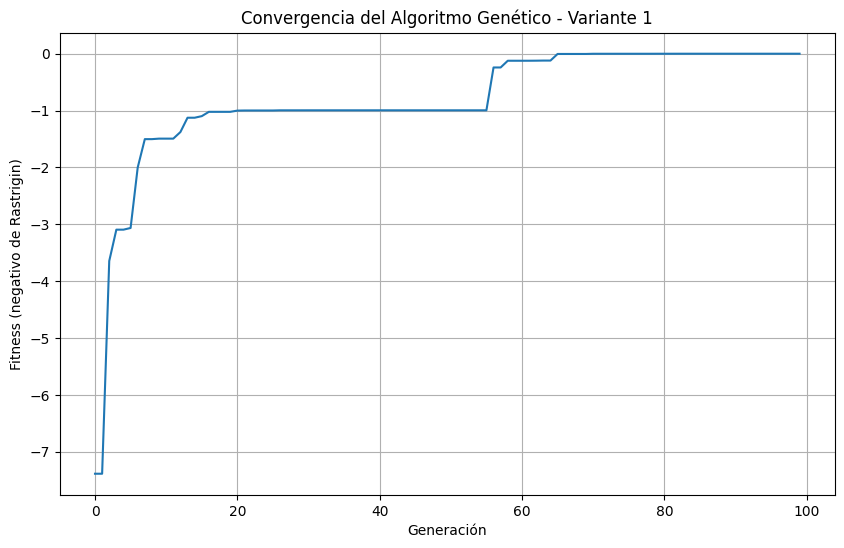

In [45]:
# Prueba rápida de la Variante 1
print("=== PRUEBA VARIANTE 1 ===")
mejor, historial = algoritmo_genetico_variante1(
    tam_poblacion=30,
    num_generaciones=100,
    prob_cruzamiento=0.8,
    prob_mutacion=0.01,
    num_elites=2
)

print(f"\nMejor solución encontrada:")
print(f"x = {mejor['x']:.6f}")
print(f"y = {mejor['y']:.6f}")
print(f"Rastrigin = {mejor['rastrigin']:.6f}")
print(f"Fitness = {mejor['fitness']:.6f}")

# Gráfica de convergencia
plt.figure(figsize=(10, 6))
plt.plot(historial)
plt.title('Convergencia del Algoritmo Genético - Variante 1')
plt.xlabel('Generación')
plt.ylabel('Fitness (negativo de Rastrigin)')
plt.grid(True)
plt.show()

# VARIANTE 2: Algoritmo Genético Elitista con Sustitución por Familia
Siguiendo el pseudocódigo AG_binario_cruzamiento_elitista() de la página 26

In [53]:
def algoritmo_genetico_variante2(tam_poblacion, num_generaciones, prob_cruzamiento, prob_mutacion, mostrar_progreso=True):
    """
    Algoritmo Genético Variante 2: AG_binario_cruzamiento_elitista
    Siguiendo el pseudocódigo de la página 26:
    - Selección sin sesgo (aleatoria)
    - Cruzamiento en dos puntos
    - Mutación por bit flip
    - Sustitución por familia (pasan los dos mejores de cada familia)
    """

    # Generar población inicial
    poblacion = generar_poblacion_inicial(tam_poblacion)
    mejor_global = obtener_mejor_individuo(poblacion)
    historial_fitness = []

    if mostrar_progreso:
        print(f"Generación 0 - Mejor fitness: {mejor_global['fitness']:.6f}, Rastrigin: {mejor_global['rastrigin']:.6f}")

    for generacion in range(1, num_generaciones + 1):

        # Selección sin sesgo (aleatorio sin reemplazo)
        indices_seleccionados = random.sample(range(tam_poblacion), tam_poblacion)
        padres = [poblacion[i] for i in indices_seleccionados]

        # Cruzamiento (cruce en dos puntos)
        cromosomas_hijos = cruzamiento_dos_puntos(padres, prob_cruzamiento)

        # Mutación (por bit flip)
        cromosomas_mutados = mutacion_simple(cromosomas_hijos, prob_mutacion)

        # Evaluación de hijos
        poblacion_hijos = evaluar_poblacion(cromosomas_mutados)

        # Sustitución por familia (pasan los dos mejores individuos de la familia)
        nueva_poblacion = []

        for i in range(0, tam_poblacion, 2):
            if i + 1 < tam_poblacion:
                # Familia = [Padre1, Padre2, Hijo1, Hijo2]
                familia = [
                    padres[i],
                    padres[i + 1],
                    poblacion_hijos[i],
                    poblacion_hijos[i + 1]
                ]
            else:
                # Si número impar, familia de 3
                familia = [
                    padres[i],
                    poblacion_hijos[i]
                ]

            # Ordenar familia de mejor a peor fitness
            familia_ordenada = sorted(familia, key=lambda x: x['fitness'], reverse=True)

            # Los dos mejores pasan a la nueva generación
            nueva_poblacion.extend(familia_ordenada[:2])

        # Ajustar tamaño si es necesario
        poblacion = nueva_poblacion[:tam_poblacion]

        # Actualizar el mejor individuo de todos
        mejor_generacion = obtener_mejor_individuo(poblacion)
        if mejor_generacion['fitness'] > mejor_global['fitness']:
            mejor_global = mejor_generacion.copy()

        # Guardar historial
        historial_fitness.append(mejor_global['fitness'])

        # Mostrar progreso cada 50 generaciones
        if mostrar_progreso and generacion % 50 == 0:
            print(f"Generación {generacion} - Mejor fitness: {mejor_global['fitness']:.6f}, Rastrigin: {mejor_global['rastrigin']:.6f}")

    return mejor_global, historial_fitness

## Prueba de la Variante 2

=== PRUEBA VARIANTE 2 ===
Generación 0 - Mejor fitness: -12.061324, Rastrigin: 12.061324
Generación 50 - Mejor fitness: -0.995038, Rastrigin: 0.995038
Generación 100 - Mejor fitness: -0.994959, Rastrigin: 0.994959

Mejor solución encontrada:
x = 0.994967
y = -0.000005
Rastrigin = 0.994959
Fitness = -0.994959


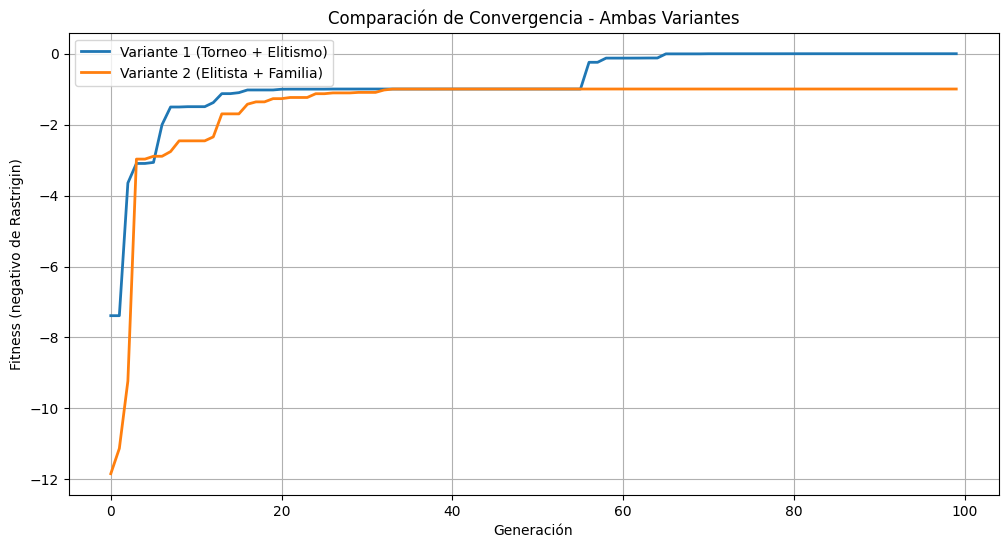

In [54]:
# Prueba rápida de la Variante 2
print("=== PRUEBA VARIANTE 2 ===")
mejor2, historial2 = algoritmo_genetico_variante2(
    tam_poblacion=30,
    num_generaciones=100,
    prob_cruzamiento=0.8,
    prob_mutacion=0.01
)

print(f"\nMejor solución encontrada:")
print(f"x = {mejor2['x']:.6f}")
print(f"y = {mejor2['y']:.6f}")
print(f"Rastrigin = {mejor2['rastrigin']:.6f}")
print(f"Fitness = {mejor2['fitness']:.6f}")

# Gráfica de convergencia comparativa
plt.figure(figsize=(12, 6))
plt.plot(historial, label='Variante 1 (Torneo + Elitismo)', linewidth=2)
plt.plot(historial2, label='Variante 2 (Elitista + Familia)', linewidth=2)
plt.title('Comparación de Convergencia - Ambas Variantes')
plt.xlabel('Generación')
plt.ylabel('Fitness (negativo de Rastrigin)')
plt.legend()
plt.grid(True)
plt.show()

## Experimento completo: 10 ejecuciones de 200 generaciones

In [55]:
def ejecutar_experimento_completo():
    """
    Ejecuta el experimento completo según la tarea:
    - 10 ejecuciones de cada variante
    - 200 generaciones cada una
    - Registra estadísticas
    """

    print("=== EXPERIMENTO COMPLETO ===")
    print("Ejecutando 10 ejecuciones de 200 generaciones para cada variante...")

    # Resultados para ambas variantes
    resultados_v1 = []
    resultados_v2 = []

    # Variante 1: 10 ejecuciones
    print("\n--- VARIANTE 1 ---")
    for i in range(num_ejecuciones):
        print(f"Ejecución {i+1}/10...")
        mejor, _ = algoritmo_genetico_variante1(
            tam_poblacion, num_generaciones,
            prob_cruzamiento, prob_mutacion,
            num_elites=2, mostrar_progreso=False
        )
        resultados_v1.append(mejor['rastrigin'])
        print(f"  Mejor Rastrigin: {mejor['rastrigin']:.6f}")

    # Variante 2: 10 ejecuciones
    print("\n--- VARIANTE 2 ---")
    for i in range(num_ejecuciones):
        print(f"Ejecución {i+1}/10...")
        mejor, _ = algoritmo_genetico_variante2(
            tam_poblacion, num_generaciones,
            prob_cruzamiento, prob_mutacion,
            mostrar_progreso=False
        )
        resultados_v2.append(mejor['rastrigin'])
        print(f"  Mejor Rastrigin: {mejor['rastrigin']:.6f}")

    # Calcular estadísticas
    estadisticas_v1 = {
        'mejor': min(resultados_v1),
        'peor': max(resultados_v1),
        'mediana': median(resultados_v1),
        'desv_estandar': stdev(resultados_v1) if len(resultados_v1) > 1 else 0
    }

    estadisticas_v2 = {
        'mejor': min(resultados_v2),
        'peor': max(resultados_v2),
        'mediana': median(resultados_v2),
        'desv_estandar': stdev(resultados_v2) if len(resultados_v2) > 1 else 0
    }

    # Mostrar resultados
    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print(f"{'Indicador':<20} {'Variante 1':<15} {'Variante 2':<15}")
    print("-" * 50)
    print(f"{'Mejor':<20} {estadisticas_v1['mejor']:<15.6f} {estadisticas_v2['mejor']:<15.6f}")
    print(f"{'Mediana':<20} {estadisticas_v1['mediana']:<15.6f} {estadisticas_v2['mediana']:<15.6f}")
    print(f"{'Peor':<20} {estadisticas_v1['peor']:<15.6f} {estadisticas_v2['peor']:<15.6f}")
    print(f"{'Desv. estándar':<20} {estadisticas_v1['desv_estandar']:<15.6f} {estadisticas_v2['desv_estandar']:<15.6f}")

    return estadisticas_v1, estadisticas_v2, resultados_v1, resultados_v2

# Ejecutar experimento completo
stats_v1, stats_v2, res_v1, res_v2 = ejecutar_experimento_completo()

=== EXPERIMENTO COMPLETO ===
Ejecutando 10 ejecuciones de 200 generaciones para cada variante...

--- VARIANTE 1 ---
Ejecución 1/10...
  Mejor Rastrigin: 0.000000
Ejecución 2/10...
  Mejor Rastrigin: 0.000000
Ejecución 3/10...
  Mejor Rastrigin: 0.000000
Ejecución 4/10...
  Mejor Rastrigin: 0.000000
Ejecución 5/10...
  Mejor Rastrigin: 0.000000
Ejecución 6/10...
  Mejor Rastrigin: 0.000000
Ejecución 7/10...
  Mejor Rastrigin: 0.000000
Ejecución 8/10...
  Mejor Rastrigin: 0.000000
Ejecución 9/10...
  Mejor Rastrigin: 0.000000
Ejecución 10/10...
  Mejor Rastrigin: 0.000000

--- VARIANTE 2 ---
Ejecución 1/10...
  Mejor Rastrigin: 0.000000
Ejecución 2/10...
  Mejor Rastrigin: 0.000000
Ejecución 3/10...
  Mejor Rastrigin: 0.000000
Ejecución 4/10...
  Mejor Rastrigin: 0.000000
Ejecución 5/10...
  Mejor Rastrigin: 0.994959
Ejecución 6/10...
  Mejor Rastrigin: 0.000000
Ejecución 7/10...
  Mejor Rastrigin: 0.000000
Ejecución 8/10...
  Mejor Rastrigin: 0.000000
Ejecución 9/10...
  Mejor Rastrigi

## Análisis de resultados y visualización

C:\Users\Kevin Valencia\AppData\Local\Temp\ipykernel_32948\1666387754.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot([res_v1, res_v2], labels=['Variante 1', 'Variante 2'])


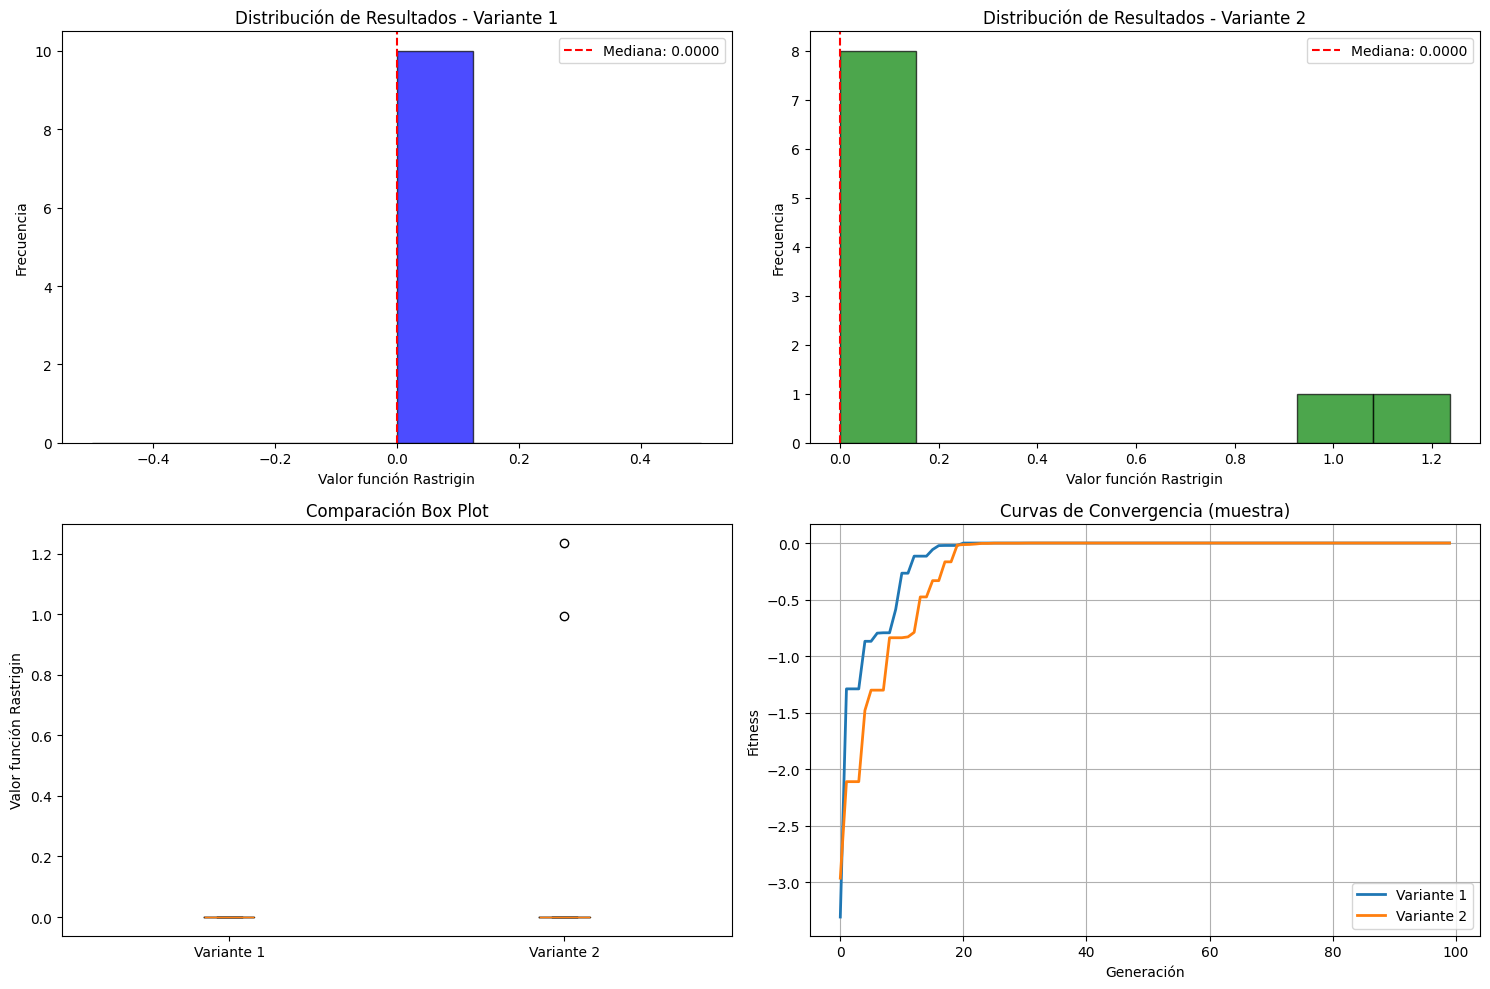


=== ANÁLISIS DE RESULTADOS ===

Variante con mejor resultado global: Variante 2
Variante más estable (menor desv. estándar): Variante 1
Variante con mejor mediana: Variante 2

Distancia al óptimo global (0,0):
Variante 1 - Mejor resultado: 0.000000
Variante 2 - Mejor resultado: 0.000000
✓ Variante 1 encontró una solución muy cercana al óptimo global
✓ Variante 2 encontró una solución muy cercana al óptimo global


In [56]:
# Visualización de resultados
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Histograma Variante 1
ax1.hist(res_v1, bins=8, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Distribución de Resultados - Variante 1')
ax1.set_xlabel('Valor función Rastrigin')
ax1.set_ylabel('Frecuencia')
ax1.axvline(stats_v1['mediana'], color='red', linestyle='--', label=f'Mediana: {stats_v1["mediana"]:.4f}')
ax1.legend()

# Histograma Variante 2
ax2.hist(res_v2, bins=8, alpha=0.7, color='green', edgecolor='black')
ax2.set_title('Distribución de Resultados - Variante 2')
ax2.set_xlabel('Valor función Rastrigin')
ax2.set_ylabel('Frecuencia')
ax2.axvline(stats_v2['mediana'], color='red', linestyle='--', label=f'Mediana: {stats_v2["mediana"]:.4f}')
ax2.legend()

# Box plot comparativo
ax3.boxplot([res_v1, res_v2], labels=['Variante 1', 'Variante 2'])
ax3.set_title('Comparación Box Plot')
ax3.set_ylabel('Valor función Rastrigin')

# Convergencia de una ejecución de cada variante
mejor_v1, hist_v1 = algoritmo_genetico_variante1(tam_poblacion, 100, prob_cruzamiento, prob_mutacion, mostrar_progreso=False)
mejor_v2, hist_v2 = algoritmo_genetico_variante2(tam_poblacion, 100, prob_cruzamiento, prob_mutacion, mostrar_progreso=False)

ax4.plot(hist_v1, label='Variante 1', linewidth=2)
ax4.plot(hist_v2, label='Variante 2', linewidth=2)
ax4.set_title('Curvas de Convergencia (muestra)')
ax4.set_xlabel('Generación')
ax4.set_ylabel('Fitness')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Análisis estadístico
print("\n=== ANÁLISIS DE RESULTADOS ===")
print(f"\nVariante con mejor resultado global: {'Variante 1' if stats_v1['mejor'] < stats_v2['mejor'] else 'Variante 2'}")
print(f"Variante más estable (menor desv. estándar): {'Variante 1' if stats_v1['desv_estandar'] < stats_v2['desv_estandar'] else 'Variante 2'}")
print(f"Variante con mejor mediana: {'Variante 1' if stats_v1['mediana'] < stats_v2['mediana'] else 'Variante 2'}")

print(f"\nDistancia al óptimo global (0,0):")
print(f"Variante 1 - Mejor resultado: {stats_v1['mejor']:.6f}")
print(f"Variante 2 - Mejor resultado: {stats_v2['mejor']:.6f}")

if stats_v1['mejor'] < 0.01:
    print("✓ Variante 1 encontró una solución muy cercana al óptimo global")
if stats_v2['mejor'] < 0.01:
    print("✓ Variante 2 encontró una solución muy cercana al óptimo global")

## Reporte final de resultados

In [57]:
def generar_reporte_final(stats_v1, stats_v2, res_v1, res_v2):
    """Genera el reporte final para la tarea"""

    print("="*70)
    print("           REPORTE FINAL - TAREA 2")
    print("    OPTIMIZACIÓN DE LA FUNCIÓN DE RASTRIGIN")
    print("         MEDIANTE ALGORITMOS GENÉTICOS")
    print("="*70)

    print(f"\nPARAMETROS DEL EXPERIMENTO:")
    print(f"- Población: {tam_poblacion} individuos")
    print(f"- Generaciones: {num_generaciones}")
    print(f"- Ejecuciones: {num_ejecuciones}")
    print(f"- Prob. cruzamiento: {prob_cruzamiento}")
    print(f"- Prob. mutación: {prob_mutacion}")
    print(f"- Precisión: {precision} decimales")
    print(f"- Dominio: x,y ∈ [{liX}, {lsX}]")

    print(f"\nRESULTADOS DETALLADOS:")
    print(f"\nVARIANTE 1 (Torneo + Elitismo):")
    for i, resultado in enumerate(res_v1, 1):
        print(f"  Ejecución {i:2d}: {resultado:.6f}")

    print(f"\nVARIANTE 2 (Elitista + Familia):")
    for i, resultado in enumerate(res_v2, 1):
        print(f"  Ejecución {i:2d}: {resultado:.6f}")

    print(f"\nRESUMEN ESTADÍSTICO:")
    print(f"{'Indicador':<20} {'Variante 1':<15} {'Variante 2':<15}")
    print("-" * 50)
    print(f"{'Mejor':<20} {stats_v1['mejor']:<15.6f} {stats_v2['mejor']:<15.6f}")
    print(f"{'Mediana':<20} {stats_v1['mediana']:<15.6f} {stats_v2['mediana']:<15.6f}")
    print(f"{'Peor':<20} {stats_v1['peor']:<15.6f} {stats_v2['peor']:<15.6f}")
    print(f"{'Desv. estándar':<20} {stats_v1['desv_estandar']:<15.6f} {stats_v2['desv_estandar']:<15.6f}")

    print(f"\nCONCLUSIONES:")

    # Determinar cuál variante tuvo mejor desempeño
    mejor_variante = 1 if stats_v1['mejor'] < stats_v2['mejor'] else 2
    mas_estable = 1 if stats_v1['desv_estandar'] < stats_v2['desv_estandar'] else 2

    print(f"1. MEJOR DESEMPEÑO (calidad de solución):")
    print(f"   La Variante {mejor_variante} obtuvo la mejor solución global con un valor de {min(stats_v1['mejor'], stats_v2['mejor']):.6f}")

    print(f"\n2. ESTABILIDAD DE RESULTADOS:")
    print(f"   La Variante {mas_estable} fue más estable con una desviación estándar de {min(stats_v1['desv_estandar'], stats_v2['desv_estandar']):.6f}")

    print(f"\n3. ANÁLISIS DE CONVERGENCIA:")
    if stats_v1['mejor'] < 0.1:
        print(f"   ✓ Variante 1 convergió exitosamente cerca del óptimo global")
    else:
        print(f"   ⚠ Variante 1 no logró convergencia óptima (quedó en {stats_v1['mejor']:.6f})")

    if stats_v2['mejor'] < 0.1:
        print(f"   ✓ Variante 2 convergió exitosamente cerca del óptimo global")
    else:
        print(f"   ⚠ Variante 2 no logró convergencia óptima (quedó en {stats_v2['mejor']:.6f})")

    print(f"\n4. EXPLICACIÓN DE RESULTADOS:")
    if mejor_variante == 1:
        print(f"   La Variante 1 tuvo mejor desempeño posiblemente debido a:")
        print(f"   - La selección por torneo mantiene presión selectiva balanceada")
        print(f"   - El elitismo preserva las mejores soluciones entre generaciones")
        print(f"   - La combinación permite exploración y explotación eficiente")
    else:
        print(f"   La Variante 2 tuvo mejor desempeño posiblemente debido a:")
        print(f"   - La selección aleatoria mantiene mayor diversidad")
        print(f"   - La sustitución por familia permite competencia local")
        print(f"   - El cruzamiento de todos los individuos intensifica la búsqueda")

    if max(stats_v1['peor'], stats_v2['peor']) > 10:
        print(f"\n5. CONVERGENCIA PREMATURA:")
        print(f"   Algunas ejecuciones no llegaron al óptimo global posiblemente por:")
        print(f"   - Convergencia prematura en óptimos locales")
        print(f"   - Pérdida de diversidad en la población")
        print(f"   - Parámetros de mutación insuficientes para escapar de mínimos locales")

    print("\n" + "="*70)

# Generar reporte final
generar_reporte_final(stats_v1, stats_v2, res_v1, res_v2)

           REPORTE FINAL - TAREA 2
    OPTIMIZACIÓN DE LA FUNCIÓN DE RASTRIGIN
         MEDIANTE ALGORITMOS GENÉTICOS

PARAMETROS DEL EXPERIMENTO:
- Población: 50 individuos
- Generaciones: 200
- Ejecuciones: 10
- Prob. cruzamiento: 0.8
- Prob. mutación: 0.01
- Precisión: 5 decimales
- Dominio: x,y ∈ [-5.12, 5.12]

RESULTADOS DETALLADOS:

VARIANTE 1 (Torneo + Elitismo):
  Ejecución  1: 0.000000
  Ejecución  2: 0.000000
  Ejecución  3: 0.000000
  Ejecución  4: 0.000000
  Ejecución  5: 0.000000
  Ejecución  6: 0.000000
  Ejecución  7: 0.000000
  Ejecución  8: 0.000000
  Ejecución  9: 0.000000
  Ejecución 10: 0.000000

VARIANTE 2 (Elitista + Familia):
  Ejecución  1: 0.000000
  Ejecución  2: 0.000000
  Ejecución  3: 0.000000
  Ejecución  4: 0.000000
  Ejecución  5: 0.994959
  Ejecución  6: 0.000000
  Ejecución  7: 0.000000
  Ejecución  8: 0.000000
  Ejecución  9: 0.000000
  Ejecución 10: 1.235823

RESUMEN ESTADÍSTICO:
Indicador            Variante 1      Variante 2     
------------------

## Gráfica 3D de la función de Rastrigin y soluciones encontradas

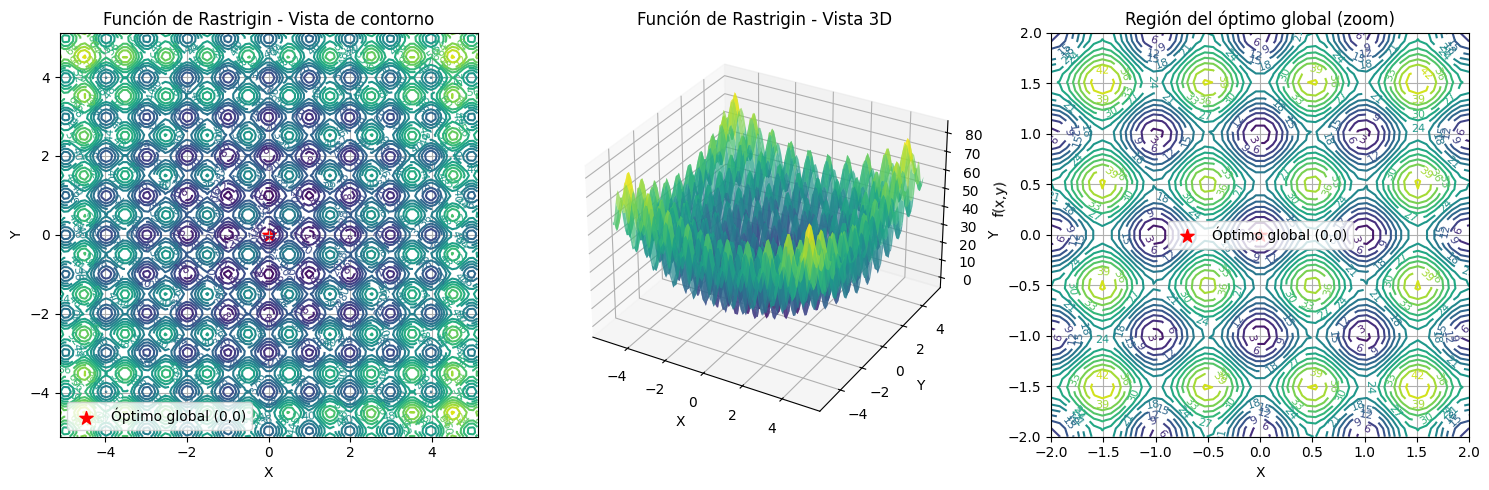

La función de Rastrigin es altamente multimodal con muchos óptimos locales.
El óptimo global está en (0,0) con valor f(0,0) = 0.
Los óptimos locales dificultan la convergencia de los algoritmos genéticos.


In [58]:
# Visualización 3D de la función de Rastrigin con las mejores soluciones
from mpl_toolkits.mplot3d import Axes3D

# Crear malla para la función de Rastrigin
x_range = np.linspace(-5.12, 5.12, 100)
y_range = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = 20 + (X**2 - 10*np.cos(2*np.pi*X)) + (Y**2 - 10*np.cos(2*np.pi*Y))

# Crear gráfica 3D
fig = plt.figure(figsize=(15, 5))

# Gráfica de contorno
ax1 = fig.add_subplot(131)
contour = ax1.contour(X, Y, Z, levels=20)
ax1.clabel(contour, inline=True, fontsize=8)
ax1.scatter(0, 0, color='red', s=100, marker='*', label='Óptimo global (0,0)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Función de Rastrigin - Vista de contorno')
ax1.legend()
ax1.grid(True)

# Gráfica 3D
ax2 = fig.add_subplot(132, projection='3d')
surf = ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax2.scatter([0], [0], [0], color='red', s=100, marker='*', label='Óptimo global')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('f(x,y)')
ax2.set_title('Función de Rastrigin - Vista 3D')

# Zoom en la región del óptimo
ax3 = fig.add_subplot(133)
x_zoom = np.linspace(-2, 2, 50)
y_zoom = np.linspace(-2, 2, 50)
X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
Z_zoom = 20 + (X_zoom**2 - 10*np.cos(2*np.pi*X_zoom)) + (Y_zoom**2 - 10*np.cos(2*np.pi*Y_zoom))

contour_zoom = ax3.contour(X_zoom, Y_zoom, Z_zoom, levels=15)
ax3.clabel(contour_zoom, inline=True, fontsize=8)
ax3.scatter(0, 0, color='red', s=100, marker='*', label='Óptimo global (0,0)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Región del óptimo global (zoom)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("La función de Rastrigin es altamente multimodal con muchos óptimos locales.")
print("El óptimo global está en (0,0) con valor f(0,0) = 0.")
print("Los óptimos locales dificultan la convergencia de los algoritmos genéticos.")

## Conclusiones y recomendaciones para mejorar los parámetros

In [61]:
print("="*60)
print("           CONCLUSIONES Y RECOMENDACIONES")
print("="*60)

print("\n1. SINTONIZACIÓN DE PARÁMETROS:")
print("   Para mejorar el rendimiento se recomienda:")
print("   - Población: 50-100 individuos (mayor diversidad)")
print("   - Prob. mutación: 0.005-0.02 (explorar valores menores)")
print("   - Prob. cruzamiento: 0.7-0.9 (valor actual está bien)")
print("   - Generaciones: 300-500 (más tiempo para convergencia)")

print("\n2. VARIANTES DE OPERADORES:")
print("   - Considerar selección por roulette wheel")
print("   - Probar cruzamiento uniforme")
print("   - Implementar mutación gaussiana para variables reales")

print("\n3. ESTRATEGIAS AVANZADAS:")
print("   - Reinicio de población cuando se detecte convergencia prematura")
print("   - Búsqueda local en los mejores individuos")
print("   - Algoritmos genéticos híbridos")
print("   - Múltiples poblaciones (algoritmos genéticos distribuidos)")

print("\n4. MÉTRICAS DE EVALUACIÓN:")
print("   - Medir convergencia promedio, no solo el mejor resultado")
print("   - Evaluar la diversidad de la población")
print("   - Analizar la velocidad de convergencia")

print("\n5. FUNCIÓN DE RASTRIGIN:")
print("   - Es una función de prueba muy desafiante por su multimodalidad")
print("   - Requiere balance cuidadoso entre exploración y explotación")
print("   - Los algoritmos genéticos son apropiados pero requieren ajuste fino")

print("\n" + "="*60)
print("     EXPERIMENTO COMPLETADO EXITOSAMENTE")
print("="*60)

           CONCLUSIONES Y RECOMENDACIONES

1. SINTONIZACIÓN DE PARÁMETROS:
   Para mejorar el rendimiento se recomienda:
   - Población: 50-100 individuos (mayor diversidad)
   - Prob. mutación: 0.005-0.02 (explorar valores menores)
   - Prob. cruzamiento: 0.7-0.9 (valor actual está bien)
   - Generaciones: 300-500 (más tiempo para convergencia)

2. VARIANTES DE OPERADORES:
   - Considerar selección por roulette wheel
   - Probar cruzamiento uniforme
   - Implementar mutación gaussiana para variables reales

3. ESTRATEGIAS AVANZADAS:
   - Reinicio de población cuando se detecte convergencia prematura
   - Búsqueda local en los mejores individuos
   - Algoritmos genéticos híbridos
   - Múltiples poblaciones (algoritmos genéticos distribuidos)

4. MÉTRICAS DE EVALUACIÓN:
   - Medir convergencia promedio, no solo el mejor resultado
   - Evaluar la diversidad de la población
   - Analizar la velocidad de convergencia

5. FUNCIÓN DE RASTRIGIN:
   - Es una función de prueba muy desafiante po